In [2]:
#Import packages
import os
import glob
import json
#from tqdm import tqdm

import nilearn
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix, run_glm
from nilearn.glm import fdr_threshold,threshold_stats_img
from nilearn.glm.contrasts import compute_contrast


from bids.layout import BIDSLayout, parse_file_entities

# import cortex
# from cortex import fmriprep

from nipype.interfaces.workbench.base import WBCommand
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

import hcp_utils as hcp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

from PIL import Image

import first_level_sparse_scanning as flss 
import importlib


In [67]:
# space='MNI152NLin6Asym'

# nifti = glob.glob(f'../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-{run}*{space}*preproc*nii.gz')[0]
# events = glob.glob(f'/nese/mit/group/sig/om_projects/voice/bids/data/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-0{run}*events.tsv')

# task_json = open(f"../../task-{task}_bold.json")
# task_json=json.load(task_json)
# TR=task_json['RepetitionTime']


# nscans = signal.shape[0]
# start_time = 0 * TR
# end_time = ((nscans - 1) *TR)
# frame_times = np.linspace(start_time, end_time, nscans)
# frame_times
# #get the confounds to regress against for 1st level model
# selected_confounds=flss.get_confounds(sub,task,ses,run)

In [66]:
root = '../../derivatives/events_sweep'
sub = 'voice880'
ses = '1'
task = 'nwr'
run = '1'

# all_confounds = pd.read_csv(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')
# len([col for col in all_confounds.columns if 'a_comp_cor' in col])

# task_json = open(f"../../task-{task}_bold.json")
# task_json=json.load(task_json)
# TR = task_json['RepetitionTime']
# DT = task_json['DelayTime']
original_events_file = f'{root}/sub-{sub}_ses-{ses}_task-{task}_run-0{run}_events.tsv'

# ev = pd.read_table(original_events_file)
# ev.onset = ev.onset + (TR-DT)
# ev.duration = DT
# custom_events = '../../derivatives/onset_duration_shift/test.tsv'
# ev.to_csv(custom_events, sep="\t", index=False)
# pd.read_table(custom_events).head()

# glob.glob(f'/nese/mit/group/sig/om_projects/voice/bids/data/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-0{run}*events.tsv')
#base_events = pd.read_table(events_file[0])

In [42]:
importlib.reload(flss)

bids_item = [parse_file_entities(original_events_file)]

return_type = 'z_score'
#contrast_maps = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type, [custom_events])
contrast_maps = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type)

#sparse_scan_regressors = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type)

#fit_glm = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type, [custom_events])
#ssreg = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type, [custom_events])
#dm = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type, [custom_events])

231025-12:15:41,1 nipype.interface INFO:
	 Setting dt = 110 ms

231025-12:15:41,3 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231025-12:15:41,4 nipype.interface INFO:
	 reg_scale: 43.1973
231025-12:15:41,7 nipype.interface INFO:
	 Setting dt = 110 ms

231025-12:15:41,10 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231025-12:15:41,11 nipype.interface INFO:
	 reg_scale: 43.1973
231025-12:15:41,14 nipype.interface INFO:
	 Setting dt = 110 ms

231025-12:15:41,16 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231025-12:15:41,17 nipype.interface INFO:
	 reg_scale: 43.1973
231025-12:15:41,19 nipype.interface INFO:
	 Setting dt = 110 ms

231025-12:15:41,21 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231025-12:15:41,22 nipype.interface INFO:
	 reg_scale: 43.1973
231025-12:15:41,25 nipype.interface INFO:
	 Setting dt = 110 ms

231025-12:15:41,28 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231025-12:15:41,29 nipype.interface INFO:


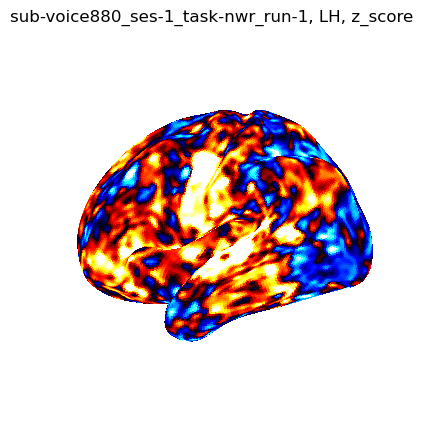

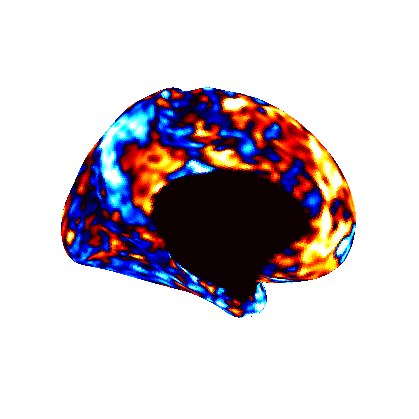

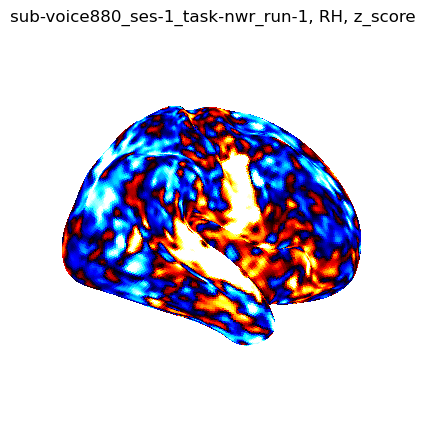

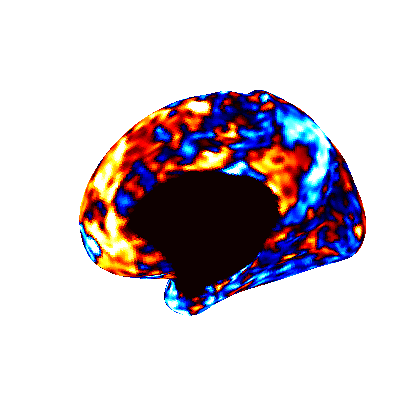

In [43]:
vmax = 3
for c in contrast_maps.columns:
    
    title = c
    nplot.plot_surf_stat_map(
        hcp.mesh.inflated, hcp.cortex_data(contrast_maps[c]), hemi='left', #threshold=thresholds[c],
        symmetric_cbar = False,
        colorbar=False,
        title = f'{title}, LH, {return_type}', #output_file=f'{root}/{c}_hemi-LH_view-lateral.png',
        title_font_size=30, vmax = vmax,
        bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated_left, hcp.left_cortex_data(contrast_maps[c]), view= 'lateral',
        hemi='right', #threshold=thresholds[c],
        symmetric_cbar = False, #output_file=f'{root}/{c}_hemi-LH_view-medial.png',
        colorbar=False, vmax = vmax,  
        bg_map=hcp.mesh.sulc_left)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated, hcp.cortex_data(contrast_maps[c]), hemi='right', #threshold=thresholds[covariate],
        symmetric_cbar = False, #output_file=f'{root}/{c}_hemi-RH_view-lateral.png',
        colorbar=False,
        title = f'{title}, RH, {return_type}', vmax = vmax,
        bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated_right, hcp.left_cortex_data(contrast_maps[c]), view= 'lateral',
        hemi='left', #threshold=thresholds[covariate],
        symmetric_cbar = False, #output_file=f'{root}/{c}_hemi-RH_view-medial.png',
        colorbar=False, vmax = vmax,
        bg_map=hcp.mesh.sulc_right)
    
    nplot.show()